# Fine-Tuning Textbook Comparison

## Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from datasets import Dataset


## Raw Data GLM

In [2]:
# ==========================================
# 1. DATA LOADING & PREPROCESSING (STRATIFIED)
# ==========================================
print("Loading freMTPL2freq dataset...")
dataset = fetch_openml(data_id=41214, as_frame=True)
dat = dataset.frame

# Clean basic types first
dat['ClaimNb'] = pd.to_numeric(dat['ClaimNb'])
dat['Exposure'] = pd.to_numeric(dat['Exposure'])
dat['Exposure'] = dat['Exposure'].clip(upper=1.0)
dat['Frequency'] = dat['ClaimNb'] / dat['Exposure']

dat = pd.get_dummies(dat, columns=['VehGas'],drop_first=True)
dat = pd.get_dummies(dat, columns=['VehBrand'],drop_first=True)
dat = pd.get_dummies(dat, columns=['Region'],drop_first=True)
area_remapping = {
    "A": 1,
    "B": 2,
    "C": 3,
    "D": 4,
    "E": 5,
    "F": 6
}
dat["Area"] = dat["Area"].map(area_remapping)

dat['VehPowerGLM'] = pd.Categorical(np.minimum(dat['VehPower'], 9))

dat['VehAgeGLM'] = pd.cut(
    dat['VehAge'],
    bins=[0, 5, 12, 101],
    labels=["0-5", "6-12", "12+"],
    include_lowest=True
)

dat['DrivAgeGLM'] = pd.cut(
    dat['DrivAge'],
    bins=[18, 20, 25, 30, 40, 50, 70, 101],
    labels=["18-20", "21-25", "26-30", "31-40", "41-50", "51-70", "71+"],
    include_lowest=True
)

dat['BonusMalusGLM'] = np.minimum(dat['BonusMalus'], 150)

dat['DensityGLM'] = np.log(dat["Density"].astype(float))

dat = pd.get_dummies(dat, columns=['DrivAgeGLM'],drop_first=True)
dat = pd.get_dummies(dat, columns=['VehAgeGLM'],drop_first=True)
dat = pd.get_dummies(dat, columns=['VehPowerGLM'],drop_first=True)

dat = dat.drop(["IDpol","VehPower", "VehAge", "DrivAge", "BonusMalus","Density"], axis = 1)
dat = dat.astype('float32')

# --- CRITICAL STEP: Create Stratification Column ---
# We stratify on whether a claim occurred (Binary) rather than the raw count.
# Stratifying on raw count (0, 1, 2, 3...) often fails because '3' claims is too rare to split.
dat['has_claim'] = dat['ClaimNb'] > 0


# --- DOWNSAMPLE 50k STRATIFIED ---
# We use train_test_split to 'pick' 50,000 rows while keeping the Claim Ratio intact.
# The 'test_size' is ignored; we just want the 'train' portion to be exactly 50k.
subset_df, _ = train_test_split(
    dat, 
    train_size=100000, 
    stratify=dat['has_claim'], # <--- Guarantees representative risk profile
    random_state=42
)

print(f"Stratified Subset Size: {len(subset_df)}")
print(f"Claim Rate in Subset: {subset_df['has_claim'].mean():.4f}")
print(f"Claim Rate in Full Data: {dat['has_claim'].mean():.4f} (Should match)")

# --- 80/20 TRAIN/TEST SPLIT ---
# Now split your 50k subset into Train/Test for modeling
train_df, test_df = train_test_split(
    subset_df, 
    test_size=0.20,
    random_state=42, 
    stratify=subset_df['has_claim'] # Stratify AGAIN to keep test set fair
)

print(f"Final Train: {len(train_df)} | Final Test: {len(test_df)}")

Loading freMTPL2freq dataset...
Stratified Subset Size: 100000
Claim Rate in Subset: 0.0502
Claim Rate in Full Data: 0.0502 (Should match)
Final Train: 80000 | Final Test: 20000


In [3]:
train_df

,ClaimNb,Exposure,Area,Frequency,VehGas_'Regular',VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,...,DrivAgeGLM_51-70,DrivAgeGLM_71+,VehAgeGLM_6-12,VehAgeGLM_12+,VehPowerGLM_5,VehPowerGLM_6,VehPowerGLM_7,VehPowerGLM_8,VehPowerGLM_9,has_claim
407825,0.0,0.77,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
13464,0.0,0.34,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False
465592,0.0,1.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,False
475594,0.0,0.16,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
454705,0.0,1.00,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618889,0.0,0.57,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
200926,0.0,0.36,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
60108,0.0,1.00,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False
570243,0.0,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,False


In [4]:
test_df

,ClaimNb,Exposure,Area,Frequency,VehGas_'Regular',VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,...,DrivAgeGLM_51-70,DrivAgeGLM_71+,VehAgeGLM_6-12,VehAgeGLM_12+,VehPowerGLM_5,VehPowerGLM_6,VehPowerGLM_7,VehPowerGLM_8,VehPowerGLM_9,has_claim
590220,0.0,0.330000,1.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False
295812,0.0,1.000000,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False
255575,0.0,1.000000,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
64900,0.0,1.000000,3.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False
66074,1.0,0.580000,3.0,1.724138,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60394,0.0,1.000000,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
83677,0.0,0.008197,4.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False
13717,0.0,0.080000,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False
650414,0.0,0.240000,4.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False


In [5]:
train_df = train_df.drop(["Frequency", "has_claim"], axis = 1).astype('float32')
test_df = test_df.drop(["Frequency", "has_claim"], axis = 1).astype('float32')

In [6]:
# Separate Predictors from Meta Data
# Using .difference() is safer/faster for 3000 columns
meta_cols = ['ClaimNb', 'Exposure']
pred_cols = train_df.columns.difference(meta_cols)

X_train = train_df[pred_cols]
meta_train = train_df[meta_cols]

X_test = test_df[pred_cols]
meta_test = test_df[meta_cols]

# Concatenate (Join)
final_train = pd.concat([X_train, meta_train], axis=1)
final_test = pd.concat([X_test, meta_test], axis=1)

print(final_train.head())

        Area  BonusMalusGLM  DensityGLM  DrivAgeGLM_21-25  DrivAgeGLM_26-30  \
407825   3.0           50.0    5.288267               0.0               0.0   
13464    5.0           90.0    7.989899               1.0               0.0   
465592   1.0           50.0    2.708050               0.0               0.0   
475594   5.0           72.0    8.596004               0.0               1.0   
454705   2.0           50.0    4.143135               0.0               0.0   

        DrivAgeGLM_31-40  DrivAgeGLM_41-50  DrivAgeGLM_51-70  DrivAgeGLM_71+  \
407825               0.0               1.0               0.0             0.0   
13464                0.0               0.0               0.0             0.0   
465592               0.0               0.0               1.0             0.0   
475594               0.0               0.0               0.0             0.0   
454705               0.0               1.0               0.0             0.0   

        Region_R21  ...  VehBrand_B5  VehBra

In [7]:
import statsmodels.api as sm
import numpy as np

# ---------------------------------------------------------
# 1. Prepare Training Data
# ---------------------------------------------------------
# Identify predictor columns (The PCs)
# We exclude 'response' and 'offset' to get just the X matrix
predictors = [c for c in final_train.columns if c not in ['ClaimNb', 'Exposure']]

X_train = final_train[predictors]
y_train = final_train['ClaimNb']

# CRITICAL: Statsmodels does not add an intercept by default.
# PCA centers data, but you still need an intercept for the baseline rate.
X_train = sm.add_constant(X_train)

# Define the offset for training
# NOTE: If 'offset' is raw exposure (e.g., years), use np.log(final_train['offset'])
train_offset = np.log(final_train['Exposure'])

# ---------------------------------------------------------
# 2. Fit the Poisson GLM
# ---------------------------------------------------------
# Instantiate the model
glm_model = sm.GLM(
    endog=y_train, 
    exog=X_train, 
    offset=train_offset,
    family=sm.families.Poisson()
)

# Fit the model
results = glm_model.fit()

print(results.summary())

# ---------------------------------------------------------
# 3. Predict on Test Data
# ---------------------------------------------------------
X_test = final_test[predictors]
X_test = sm.add_constant(X_test, has_constant='add') # Ensure structure matches Train

# Define offset for testing
test_offset = np.log(final_test['Exposure'])

# Generate Predictions (Expected Counts)
# We pass the test offset here so predictions are scaled correctly
predictions = results.predict(exog=X_test, offset=test_offset)

# Add predictions back to the test dataframe for analysis
final_test['predicted_counts'] = predictions

print("\nFirst 5 Predictions:")
print(final_test[['ClaimNb', 'Exposure', 'predicted_counts']].head())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                80000
Model:                            GLM   Df Residuals:                    79951
Model Family:                 Poisson   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16788.
Date:                Tue, 17 Feb 2026   Deviance:                       25408.
Time:                        22:41:22   Pearson chi2:                 2.05e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01008
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9306      0.196  

In [8]:
# 1. Access the Poisson family object from your fitted model
poisson_family = results.family

# 2. Calculate Total Deviance for the Test Set
# Inputs: (Endog/Actual, Mu/Predicted)
test_deviance_total = poisson_family.deviance(
    final_test['ClaimNb'], 
    final_test['predicted_counts']
)

# 3. Calculate Mean Deviance
test_mean_deviance = test_deviance_total / len(final_test)

print(f"Test Mean Poisson Deviance: {test_mean_deviance:.4f}")

Test Mean Poisson Deviance: 0.3126


Size 500: 1.38555
Size 878: 1.18131
Size 1544: 0.50144
Size 2714: 0.43560
Size 4770: 0.35889
Size 8384: 0.33106
Size 14736: 0.31516
Size 25899: 0.31346
Size 45518: 0.31287
Size 80000: 0.31257


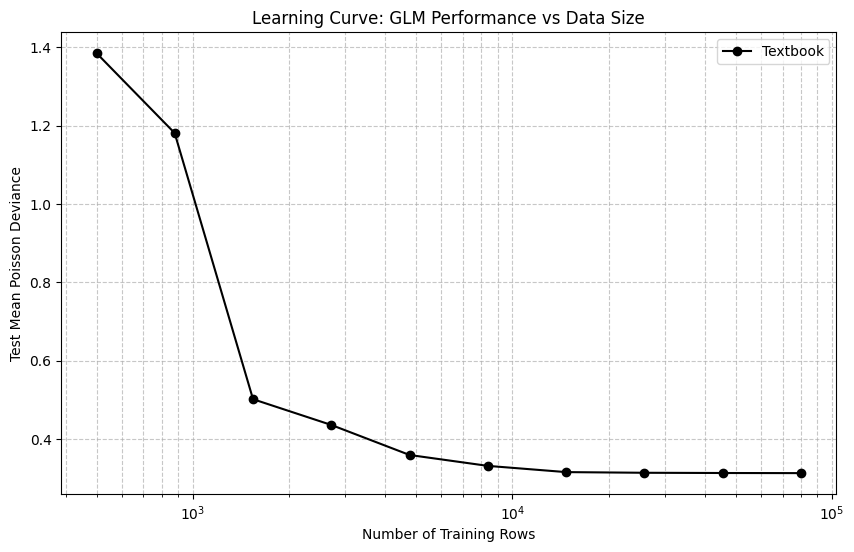

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm



meta_cols = ['ClaimNb', 'Exposure']
pred_cols = train_df.columns.difference(meta_cols)

# Prepare Matrices
X_train_raw = train_df[pred_cols]
y_train = train_df['ClaimNb']
offset_train = train_df['Exposure'] 

X_test_raw = test_df[pred_cols]
y_test = test_df['ClaimNb']
offset_test = test_df['Exposure']

# Pre-add constant to Test set (since it never changes)
X_test_glm = sm.add_constant(X_test_raw, has_constant='add')

# 3. Learning Curve Loop
# -------------------------------------------------------
train_sizesr = np.geomspace(500, 80000, num=10, dtype=int)
deviancesr_2 = []

for size in train_sizesr:
    # A. Slice the first 'size' rows from the ALREADY TRANSFORMED data
    # We use .iloc because X_train_pca_all is a dataframe
    X_train_sub = X_train_raw.iloc[:size]
    y_train_sub = y_train.iloc[:size]
    off_train_sub = offset_train.iloc[:size]
    
    # B. Add constant for Statsmodels
    X_train_glm = sm.add_constant(X_train_sub)
    
    # C. Fit GLM
    glm = sm.GLM(
        endog=y_train_sub, 
        exog=X_train_glm, 
        offset=np.log(off_train_sub), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # D. Predict on fixed Test Set
    preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    
    # E. Score
    mpd = mean_poisson_deviance(y_test, preds)
    deviancesr_2.append(mpd)
    print(f"Size {size}: {mpd:.5f}")
    

# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_sizesr, deviancesr_2, marker='o', linestyle='-', color='black', label=f'Textbook')
plt.xscale('log')
plt.title('Learning Curve: GLM Performance vs Data Size')
plt.xlabel('Number of Training Rows')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7, which = 'both')
plt.legend()

#plt.savefig('pca_learning_curve3.png')
plt.show()